## Seattle Airbnb data analysis


#### Questions that will be answered in this notebook:

1. What is the average AirBnB rental property price by neighbourhood?

2. What are the busiest times of year to visit Seattle?

3. Can we predict listing prices using linear regression?

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

import fiona

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')
reviews = pd.read_csv('reviews.csv')

In [4]:
print('Shape of calendar table is:', calendar.shape)
print('Shape of listings table is:', listings.shape)
print('Shape of reviews table is:', reviews.shape)

Shape of calendar table is: (1393570, 4)
Shape of listings table is: (3818, 92)
Shape of reviews table is: (84849, 6)


In [5]:
calendar.head()

listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN
3      241032  2016-01-07         f     NaN
4      241032  2016-01-08         f     NaN

In [6]:
print('Min date: ',min(calendar.date))
print('Max date: ',max(calendar.date))

Min date:  2016-01-04
Max date:  2017-01-02


In [7]:
len(calendar.date.unique())

365

As we can see, there are 365 days of data, between 2016-01-04 and 2017-01-02 (including leap day 2016-02-29). 

In [8]:
listings.head()

id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   
3                                                NaN   
4  Cozy family craftman house in beautiful neighb...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   
1  Chemically sensitive? We've removed the irrita...                none   
2  New modern house built in 2013.  Spectacular s...                none   
3  A charming apartment that sits atop Queen Anne...                none   
4  Cozy family craftman house in beautiful neighb...                none   

                               neighborhood_overview  ... review_scores_value  \
0                                                NaN  ...                10.0   
1  Queen Anne is a wonderful, truly functional vi...  ...                10.0   
2  Upper Queen Anne is a charming neighborhood fu...  ...                10.0   
3                                                NaN  ...                 NaN   
4  We are in the beautiful neighborhood of Queen ...  ...                 9.0   

  requires_license license jurisdiction_names instant_bookable  \
0                f     NaN         WASHINGTON                f   
1                f     NaN         WASHINGTON                f   
2                f     NaN         WASHINGTON                f   
3                f     NaN         WASHINGTON                f   
4                f     NaN         WASHINGTON                f   

  cancellation_policy  require_guest_profile_picture  \
0            moderate                              f   
1              strict                              t   
2              strict                              f   
3            flexible                              f   
4              strict                              f   

  require_guest_phone_verification calculated_host_listings_count  \
0                                f                              2   
1                                t                              6   
2                                f                              2   
3                                f                              1   
4                                f                              1   

  reviews_per_month  
0              4.07  
1              1.48  
2              1.15  
3               NaN  
4              0.89  

[5 rows x 92 columns]

In [9]:
len(listings.id.unique())

3818

We have data about 3818 available listings.

In [10]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [12]:
reviews.head()

listing_id        id        date  reviewer_id reviewer_name  \
0     7202016  38917982  2015-07-19     28943674        Bianca   
1     7202016  39087409  2015-07-20     32440555         Frank   
2     7202016  39820030  2015-07-26     37722850           Ian   
3     7202016  40813543  2015-08-02     33671805        George   
4     7202016  41986501  2015-08-10     34959538          Ming   

                                            comments  
0  Cute and cozy place. Perfect location to every...  
1  Kelly has a great room in a very central locat...  
2  Very spacious apartment, and in a great neighb...  
3  Close to Seattle Center and all it has to offe...  
4  Kelly was a great host and very accommodating ...

In [79]:
#listings["price"].unique()

In [11]:
#removing dollar sign
listings["price"] = listings["price"].str.replace('$', '',regex=True) 
listings["security_deposit"] = listings["security_deposit"].str.replace('$', '',regex=True)
listings["cleaning_fee"] = listings["cleaning_fee"].str.replace('$', '',regex=True)
listings["extra_people"] = listings["extra_people"].str.replace('$', '',regex=True)

In [12]:
#removing comma sign
listings["price"] = listings["price"].str.replace(',', '',regex=True)
listings["security_deposit"] = listings["security_deposit"].str.replace(',', '',regex=True)
listings["cleaning_fee"] = listings["cleaning_fee"].str.replace(',', '',regex=True)
listings["extra_people"] = listings["extra_people"].str.replace(',', '',regex=True)

In [13]:
#listings["price"].unique()

In [14]:
listings["price"] = listings["price"].astype(float)
listings["security_deposit"] = listings["security_deposit"].astype(float)
listings["cleaning_fee"] = listings["cleaning_fee"].astype(float)
listings["extra_people"] = listings["extra_people"].astype(float)

In [81]:
#listings["price"].unique()

In [8]:
price_by_neighb = listings.groupby("neighbourhood_cleansed", as_index=False)["price"].mean()

In [9]:
#sorting the values for the bar chart
price_by_neighb.sort_values("price", ascending=False, inplace=True)

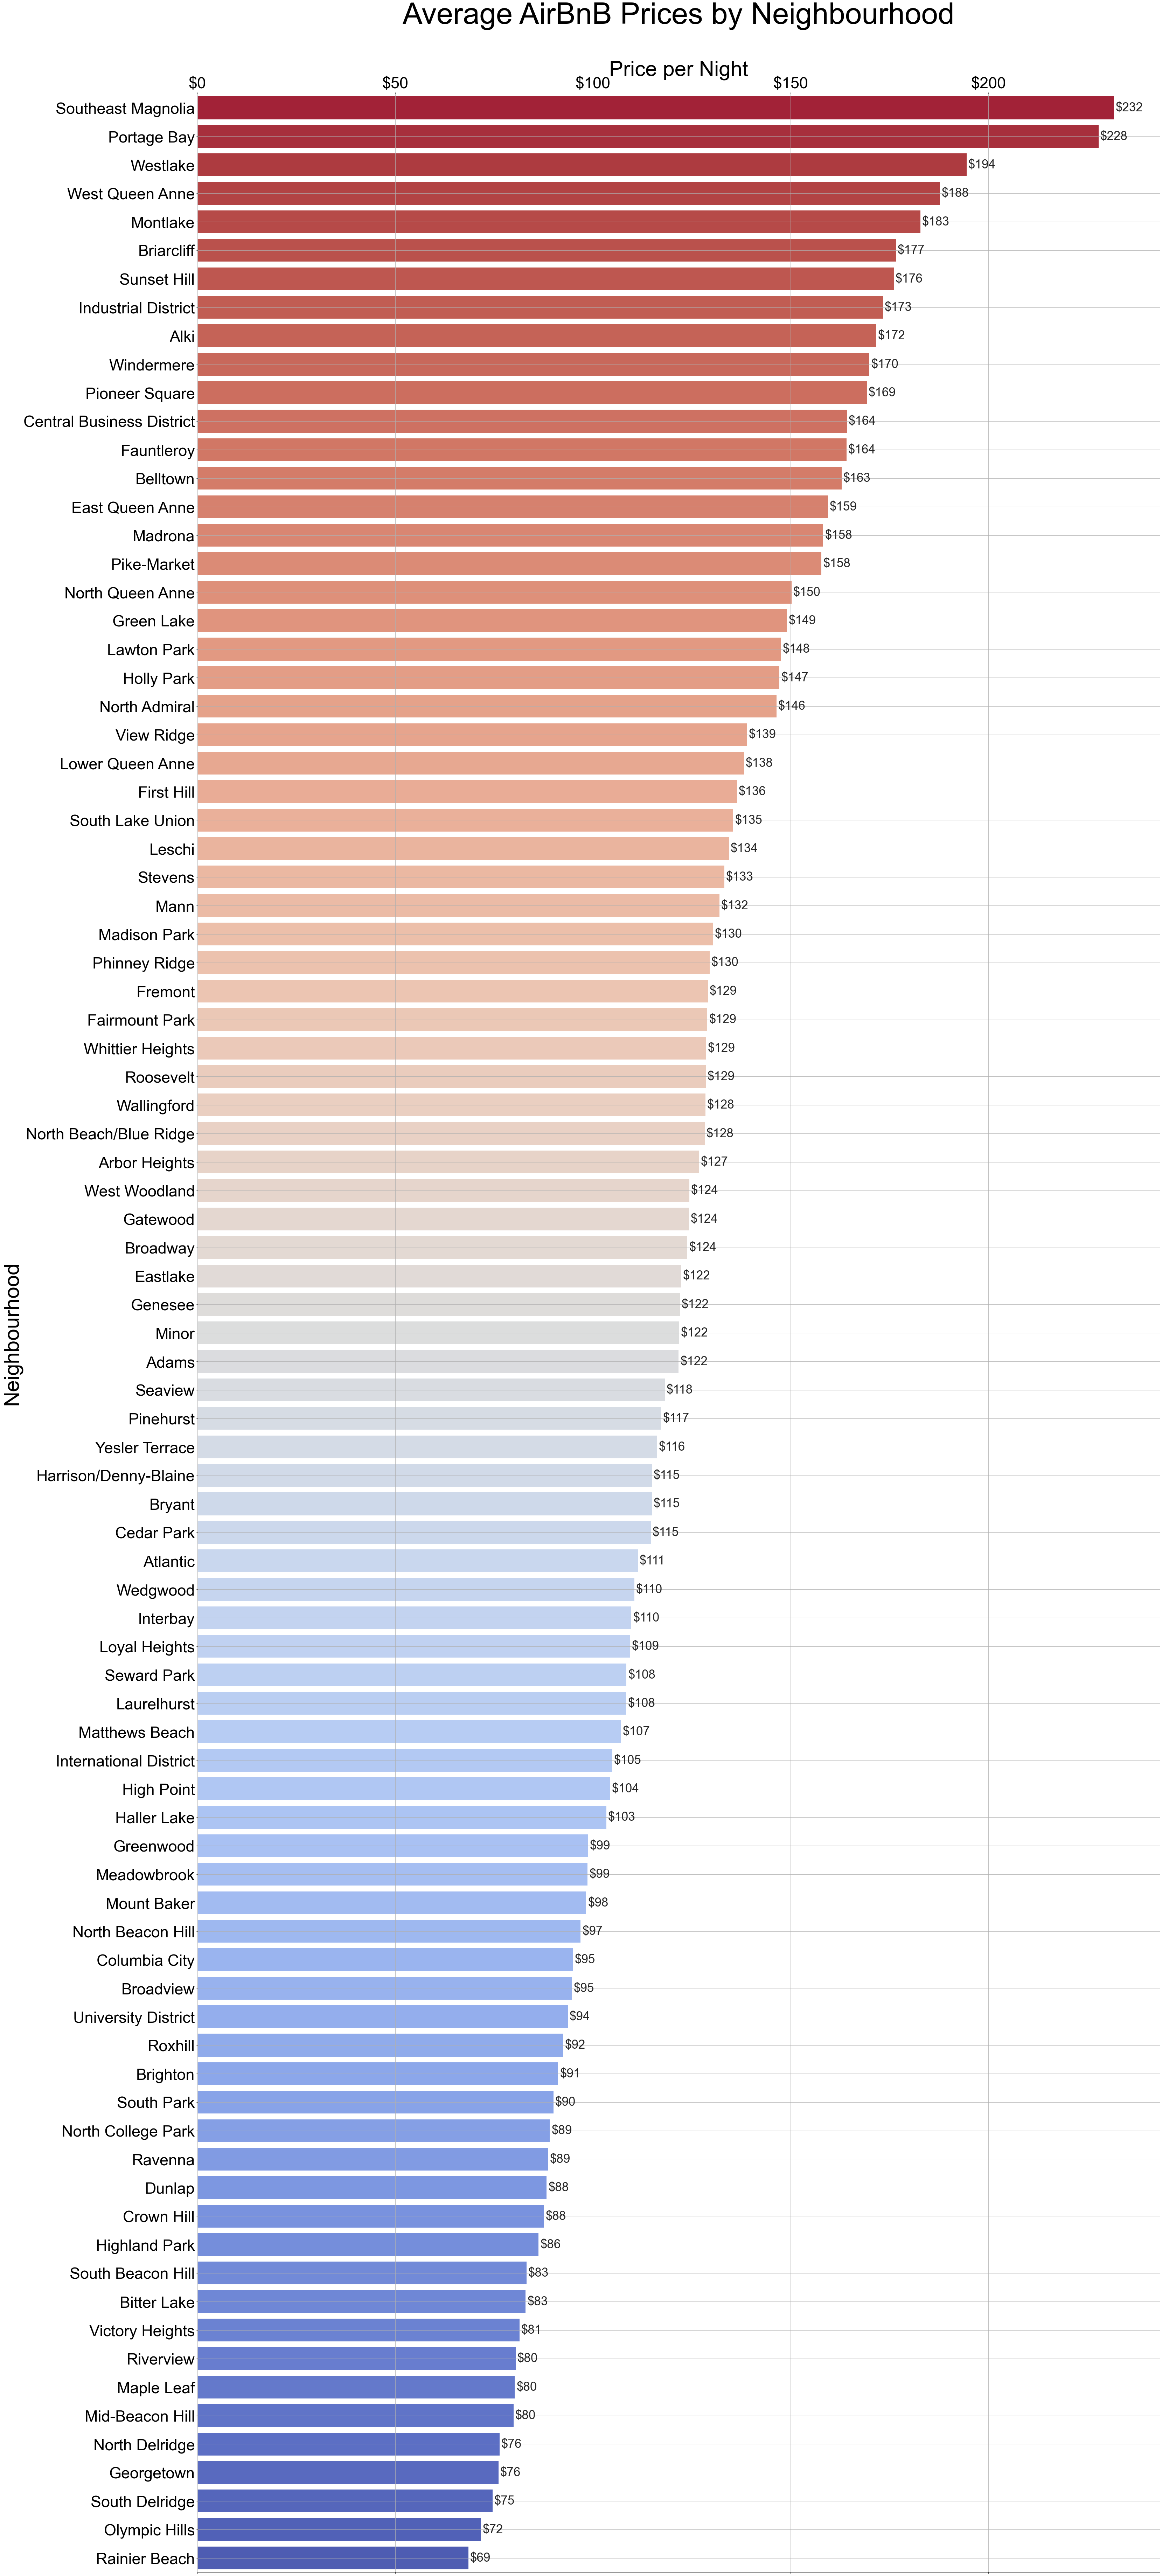

In [21]:
fig, ax = plt.subplots(figsize=(40,100))
fig.tight_layout(pad=5)


sns.barplot(x="price", y="neighbourhood_cleansed", data=price_by_neighb, palette="coolwarm_r")
sns.set_style('whitegrid')
 
plt.title("Average AirBnB Prices by Neighbourhood", fontsize=85, pad=200)

plt.xlabel("Price per Night", fontsize=60)
ax.xaxis.set_label_position('top') 
ax.xaxis.set_major_formatter('${x:1.0f}')
ax.xaxis.set_ticks_position('top')
plt.xticks(fontsize=45, rotation=None)

plt.ylabel("Neighbourhood", fontsize=60)
plt.yticks(fontsize=45)

sns.despine(bottom=False, left=True)
ax.grid(True)
ax.tick_params(bottom=True, left=True)


#Following code block for adding value labels comes from this link:
#https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart#:~:text=48-,Building,-off%20the%20above

rects = ax.patches
# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    ha = 'left'

    # If value of bar is negative: Place label left of bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label at right
        ha = 'right'

    # Use X value as label and format number with one decimal place
    label = "${:.0f}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha,                      # Horizontally align label differently for positive and negative values.
        size=35)



plt.savefig('AverageAirBnBPricesByNeighbourhood.png')



In [22]:
street_map = gpd.read_file(r'C:\Users\josip\Udacity\Seattle\StreetNetworkDatabase\Street_Network_Database_(SND).shp')

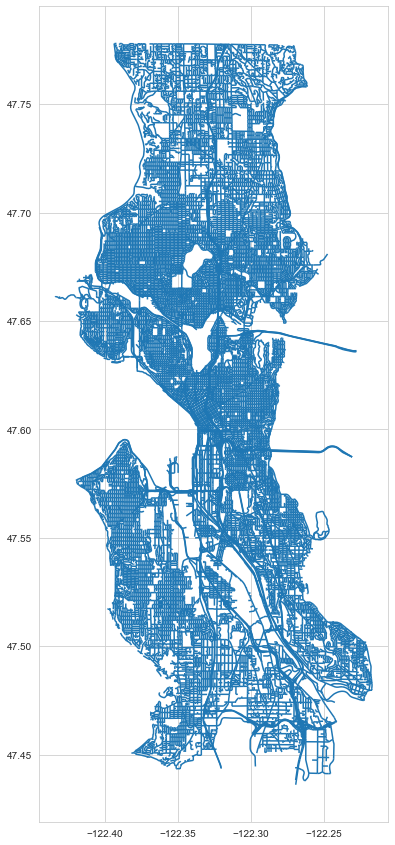

In [23]:
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax);

In [24]:
crs = ("epsg:4326")
geometry = [Point(xy) for xy in zip(listings["longitude"], listings["latitude"])]
geo_df = gpd.GeoDataFrame(listings, crs=crs, geometry=geometry)

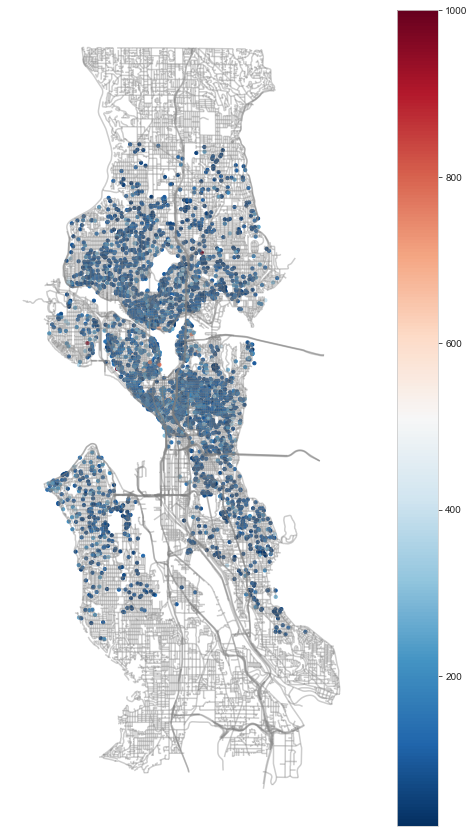

In [25]:
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.4, color="grey")
geo_df.plot(ax=ax, markersize=10, column="price", legend=True, cmap="RdBu_r")
ax.set_axis_off();

In [26]:
np.sum(listings["price"]<250)

3495

In [27]:
listings["price"].shape

(3818,)

In [30]:
#all listings that are below highest average price of 232
listings_below=listings[listings["price"]<232]
crs = ("epsg:4326")
geometry = [Point(xy) for xy in zip(listings_below["longitude"], listings_below["latitude"])]
geo_df = gpd.GeoDataFrame(listings_below, crs=crs, geometry=geometry)

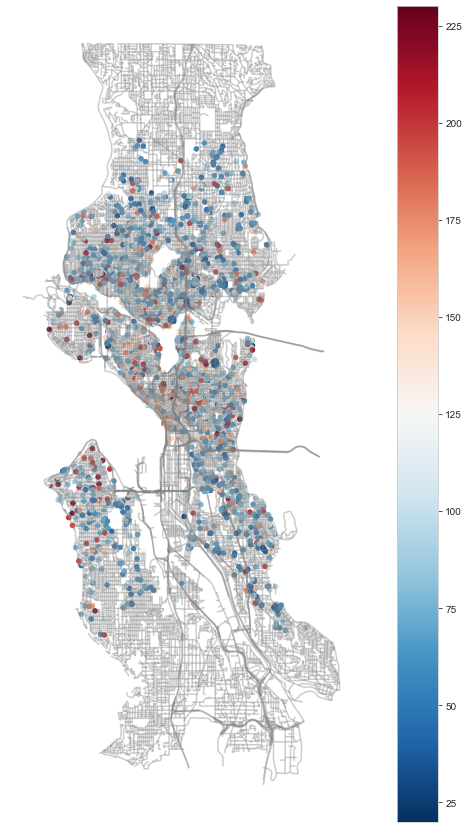

In [31]:
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.4, color="grey")
geo_df.plot(ax=ax, markersize=20, column="price", legend=True, cmap="RdBu_r")
ax.set_axis_off();

In [32]:
#all listings that are above highest average price of 232
listings_above=listings[listings["price"]>=232]
crs = ("epsg:4326")
geometry = [Point(xy) for xy in zip(listings_above["longitude"], listings_above["latitude"])]
geo_df = gpd.GeoDataFrame(listings_above, crs=crs, geometry=geometry)

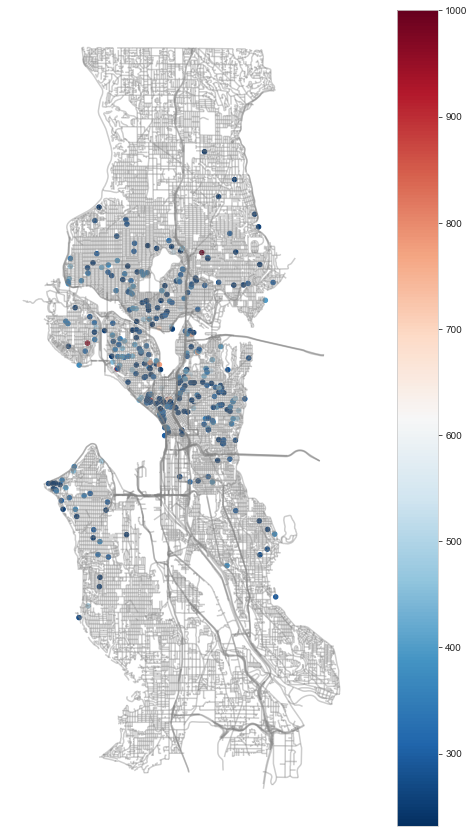

In [33]:
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.4, color="grey")
geo_df.plot(ax=ax, markersize=20, column="price", legend=True, cmap="RdBu_r")
ax.set_axis_off();

In [16]:
price_and_loc_by_neighb = listings.groupby("neighbourhood_cleansed", as_index=False).agg(
    avg_price=pd.NamedAgg(column="price", aggfunc="mean"),
    avg_latitude=pd.NamedAgg(column="latitude", aggfunc="mean"),
    avg_longitude=pd.NamedAgg(column="longitude", aggfunc="mean"))

In [17]:
price_and_loc_by_neighb

neighbourhood_cleansed   avg_price  avg_latitude  avg_longitude
0                   Adams  121.671429     47.671506    -122.386485
1                    Alki  171.619048     47.575052    -122.408047
2           Arbor Heights  126.800000     47.510429    -122.381931
3                Atlantic  111.396226     47.595164    -122.305620
4                Belltown  162.893162     47.615147    -122.345487
..                    ...         ...           ...            ...
82          West Woodland  124.343750     47.669077    -122.366817
83               Westlake  194.470588     47.631958    -122.341871
84       Whittier Heights  128.653846     47.682390    -122.371655
85             Windermere  169.900000     47.670212    -122.272097
86         Yesler Terrace  116.235294     47.604993    -122.320040

[87 rows x 4 columns]

In [36]:
crs = ("epsg:4326")
geometry = [Point(xy) for xy in zip(price_and_loc_by_neighb["avg_longitude"], price_and_loc_by_neighb["avg_latitude"])]
geo_df = gpd.GeoDataFrame(price_and_loc_by_neighb, crs=crs, geometry=geometry)

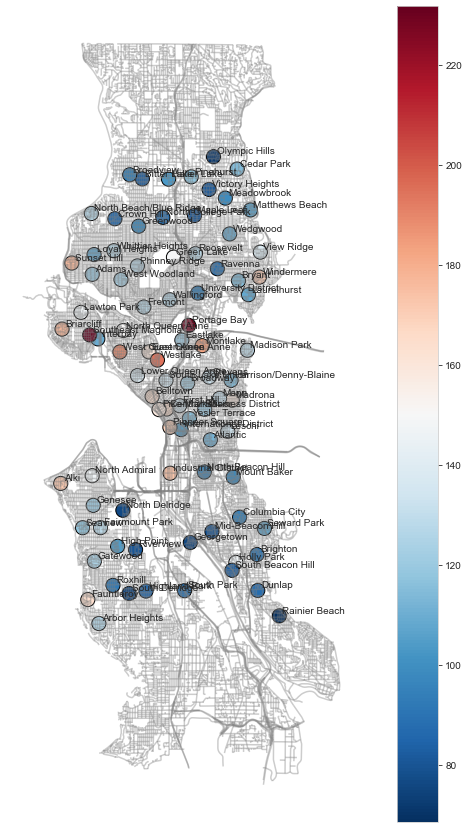

In [37]:
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.4, color="grey")
geo_df.plot(ax=ax, markersize=200, column="avg_price", legend=True, cmap="RdBu_r", edgecolor="black")

for x, y, label in zip(price_and_loc_by_neighb["avg_longitude"], price_and_loc_by_neighb["avg_latitude"], price_and_loc_by_neighb["neighbourhood_cleansed"]):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
    
ax.set_axis_off();

In [10]:
neighb_map = gpd.read_file(r'C:\Users\josip\Udacity\Seattle\City_Clerk_Neighborhoods\City_Clerk_Neighborhoods.shp')

In [11]:
neighb_map.head()

OBJECTID  PERIMETER S_HOOD L_HOOD  L_HOODID  SYMBOL  SYMBOL2       AREA  \
0         1    617.843    OOO   None         0       0        0   3588.443   
1         2    733.568    OOO   None         0       0        0  22294.777   
2         3   4088.442    OOO   None         0       0        0  56695.367   
3         4   1809.446    OOO   None         0       0        0  64156.813   
4         5    250.330    OOO   None         0       0        0   2993.164   

   HOODS_  HOODS_ID   SHAPE_Leng    SHAPE_Area  \
0       2         0   617.842614   3588.442385   
1       3         0   733.568416  22294.781706   
2       5         0  4088.441739  56695.357490   
3       6         0  1809.445748  64156.821780   
4       7         0   250.330362   2993.161328   

                                            geometry  
0  POLYGON ((-122.27398 47.69523, -122.27409 47.6...  
1  POLYGON ((-122.28756 47.64523, -122.28754 47.6...  
2  POLYGON ((-122.39529 47.66514, -122.39520 47.6...  
3  POLYGON ((-122.39832 47.66609, -122.39824 47.6...  
4  POLYGON ((-122.28851 47.65630, -122.28847 47.6...

In [11]:
neighb_map["L_HOOD"].unique()

array([None, 'BALLARD', 'NO BROADER TERM', 'UNIVERSITY DISTRICT',
       'QUEEN ANNE', 'CASCADE', 'MAGNOLIA', 'CENTRAL AREA', 'DOWNTOWN',
       'INTERBAY', 'WEST SEATTLE', 'BEACON HILL', 'RAINIER VALLEY',
       'DELRIDGE', 'SEWARD PARK', 'CAPITOL HILL', 'LAKE CITY',
       'NORTHGATE'], dtype=object)

In [12]:
map_neigborhoods=neighb_map["S_HOOD"].unique()
map_neigborhoods=pd.DataFrame(map_neigborhoods, columns=["Neighborhood"])

In [13]:
map_neigborhoods.sort_values(by=["Neighborhood"],inplace=True)

In [14]:
map_neigborhoods["Neighborhood"].unique()

array(['Adams', 'Alki', 'Arbor Heights', 'Atlantic', 'Belltown',
       'Bitter Lake', 'Briarcliff', 'Brighton', 'Broadview', 'Broadway',
       'Bryant', 'Cedar Park', 'Central Business District',
       'Columbia City', 'Crown Hill', 'Dunlap', 'East Queen Anne',
       'Eastlake', 'Fairmount Park', 'Fauntleroy', 'First Hill',
       'Fremont', 'Gatewood', 'Genesee', 'Georgetown', 'Green Lake',
       'Greenwood', 'Haller Lake', 'Harbor Island',
       'Harrison/Denny-Blaine', 'High Point', 'Highland Park',
       'Holly Park', 'Industrial District', 'Interbay',
       'International District', 'Laurelhurst', 'Lawton Park', 'Leschi',
       'Lower Queen Anne', 'Loyal Heights', 'Madison Park', 'Madrona',
       'Mann', 'Maple Leaf', 'Matthews Beach', 'Meadowbrook',
       'Mid-Beacon Hill', 'Minor', 'Montlake', 'Mount Baker',
       'North Admiral', 'North Beach/Blue Ridge', 'North Beacon Hill',
       'North College Park', 'North Delridge', 'North Queen Anne', 'OOO',
       'Olympic H

In [18]:
price_and_loc_by_neighb.neighbourhood_cleansed.unique()

array(['Adams', 'Alki', 'Arbor Heights', 'Atlantic', 'Belltown',
       'Bitter Lake', 'Briarcliff', 'Brighton', 'Broadview', 'Broadway',
       'Bryant', 'Cedar Park', 'Central Business District',
       'Columbia City', 'Crown Hill', 'Dunlap', 'East Queen Anne',
       'Eastlake', 'Fairmount Park', 'Fauntleroy', 'First Hill',
       'Fremont', 'Gatewood', 'Genesee', 'Georgetown', 'Green Lake',
       'Greenwood', 'Haller Lake', 'Harrison/Denny-Blaine', 'High Point',
       'Highland Park', 'Holly Park', 'Industrial District', 'Interbay',
       'International District', 'Laurelhurst', 'Lawton Park', 'Leschi',
       'Lower Queen Anne', 'Loyal Heights', 'Madison Park', 'Madrona',
       'Mann', 'Maple Leaf', 'Matthews Beach', 'Meadowbrook',
       'Mid-Beacon Hill', 'Minor', 'Montlake', 'Mount Baker',
       'North Admiral', 'North Beach/Blue Ridge', 'North Beacon Hill',
       'North College Park', 'North Delridge', 'North Queen Anne',
       'Olympic Hills', 'Phinney Ridge', 'Pike-M

In [45]:
crs = ("epsg:4326")
geometry = [Point(xy) for xy in zip(price_and_loc_by_neighb["avg_longitude"], price_and_loc_by_neighb["avg_latitude"])]
geo_df = gpd.GeoDataFrame(price_and_loc_by_neighb, crs=crs, geometry=geometry)

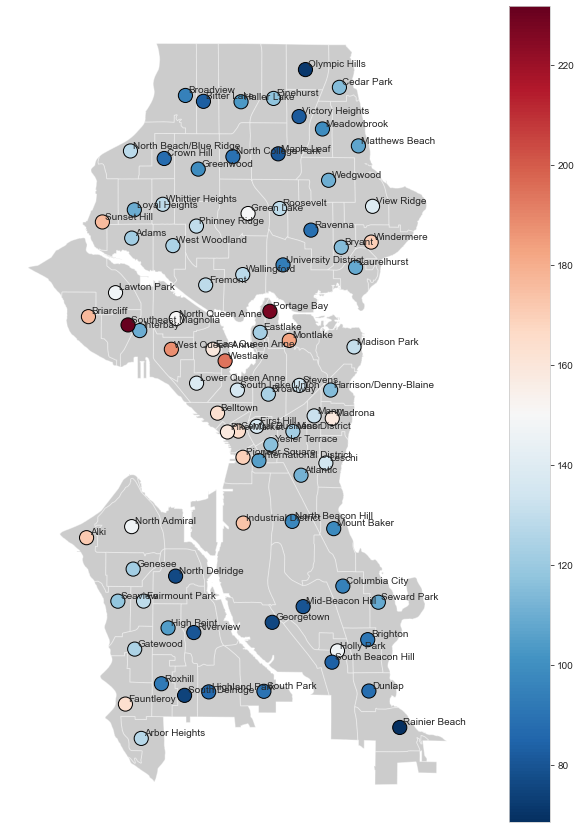

In [47]:
fig, ax = plt.subplots(figsize=(15,15))
neighb_map.plot(ax=ax, alpha=0.4, color="grey")
geo_df.plot(ax=ax, markersize=200, column="avg_price", legend=True, cmap="RdBu_r", edgecolor="black")

for x, y, label in zip(price_and_loc_by_neighb["avg_longitude"], price_and_loc_by_neighb["avg_latitude"], price_and_loc_by_neighb["neighbourhood_cleansed"]):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
    
ax.set_axis_off();

In [19]:
#in order to color neighborhoods we need to add avg price to hood_map dataframe
neighb_map_price = neighb_map.merge(price_and_loc_by_neighb, left_on="S_HOOD", right_on="neighbourhood_cleansed", how="inner")
neighb_map_price.head()

OBJECTID  PERIMETER            S_HOOD           L_HOOD  L_HOODID  SYMBOL  \
0        27  18831.010     Loyal Heights          BALLARD         7      11   
1        28  27347.494             Adams          BALLARD         7      11   
2        29  15934.439  Whittier Heights          BALLARD         7      11   
3        30  21789.650     West Woodland          BALLARD         7      11   
4        31  27120.785     Phinney Ridge  NO BROADER TERM         6       9   

   SYMBOL2        AREA  HOODS_  HOODS_ID    SHAPE_Leng    SHAPE_Area  \
0       23  21320656.0      29       120  18831.009596  2.132066e+07   
1       33  22431280.0      30       129  27347.494350  2.243128e+07   
2       24  14195687.0      31       121  15934.439266  1.419569e+07   
3        9  22199366.0      32       130  21789.651087  2.219937e+07   
4       95  32123118.0      33       126  27120.785938  3.212312e+07   

                                            geometry neighbourhood_cleansed  \
0  POLYGON ((-122.37634 47.67592, -122.37671 47.6...          Loyal Heights   
1  POLYGON ((-122.37634 47.67592, -122.37621 47.6...                  Adams   
2  POLYGON ((-122.37634 47.67592, -122.37652 47.6...       Whittier Heights   
3  POLYGON ((-122.37634 47.67592, -122.37608 47.6...          West Woodland   
4  POLYGON ((-122.34731 47.66501, -122.34887 47.6...          Phinney Ridge   

    avg_price  avg_latitude  avg_longitude  
0  109.384615     47.680611    -122.385238  
1  121.671429     47.671506    -122.386485  
2  128.653846     47.682390    -122.371655  
3  124.343750     47.669077    -122.366817  
4  129.520548     47.675370    -122.355565

In [49]:
#crs = ("epsg:4326")
#geometry = [Point(xy) for xy in zip(hood_price["avg_longitude"], hood_price["avg_latitude"])]
#geo_df = gpd.GeoDataFrame(hood_price, crs=crs, geometry=geometry)

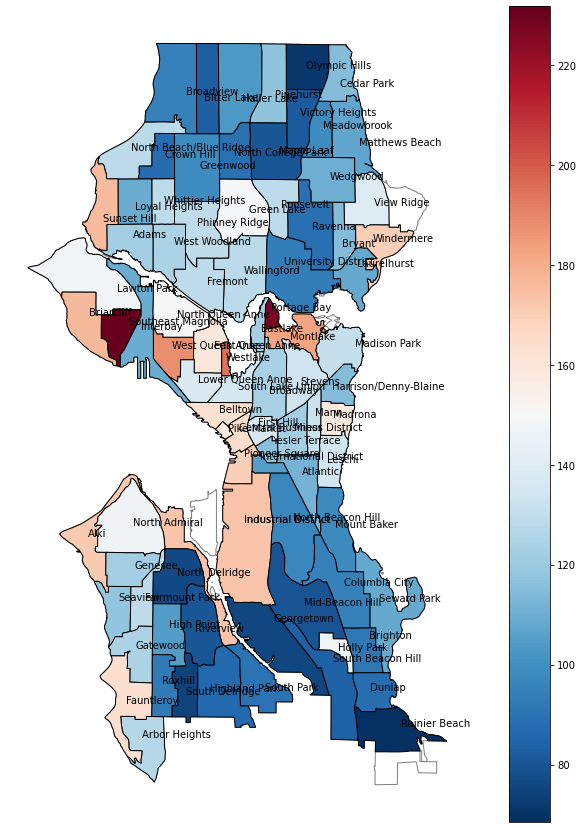

In [20]:
fig, ax = plt.subplots(figsize=(15,15))
neighb_map.plot(ax=ax, edgecolor="grey", color="white")
neighb_map_price.plot(ax=ax, edgecolor="black", column="avg_price", legend=True, cmap="RdBu_r")

for x, y, label in zip(neighb_map_price["avg_longitude"], neighb_map_price["avg_latitude"], neighb_map_price["neighbourhood_cleansed"]):
    ax.annotate(label, xy=(x, y), xytext=(1, 1), textcoords="offset points", size=10)

ax.set_axis_off();

In order to answer second question, we need "calendar" table

In [21]:
calendar = pd.read_csv('calendar.csv')

In [22]:
calendar.head()

listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN
3      241032  2016-01-07         f     NaN
4      241032  2016-01-08         f     NaN

In [23]:
calendar_available=calendar[calendar["available"]=="t"]
calendar_available=pd.DataFrame(calendar_available)

In [24]:
calendar_available["date"]=pd.to_datetime(calendar_available["date"])

In [25]:
#replacing t and f with 1s and 0s
calendar_available["available"] = calendar_available["available"].str.replace('t', '1',regex=True)
calendar_available["available"] = calendar_available["available"].str.replace('f', '0',regex=True)

#changing column type from object to integer
calendar_available["available"] = calendar_available["available"].astype(str).astype(int)

In [26]:
#removing dollar sign
calendar_available["price"] = calendar_available["price"].str.replace('$', '',regex=True)

In [27]:
#removing comma sign
calendar_available["price"] = calendar_available["price"].str.replace(',', '',regex=True)

In [28]:
calendar_available["price"] = calendar_available["price"].astype(float)

In [29]:
#calendar_available = calendar_available.groupby("date", as_index=False).agg(
#    sum_available=pd.NamedAgg(column="available", aggfunc="sum"),
#    avg_price=pd.NamedAgg(column="price", aggfunc="mean"))
#calendar_available


In [30]:
calendar_available['week'] = calendar_available['date'].dt.isocalendar().week

In [31]:
calendar_available['month'] = calendar_available['date'].dt.month

In [32]:
calendar_available_day = calendar_available.groupby("date", as_index=False).agg(
    sum_available=pd.NamedAgg(column="available", aggfunc="sum"),
    avg_price=pd.NamedAgg(column="price", aggfunc="mean"))#.count()['listing_id'].reset_index()

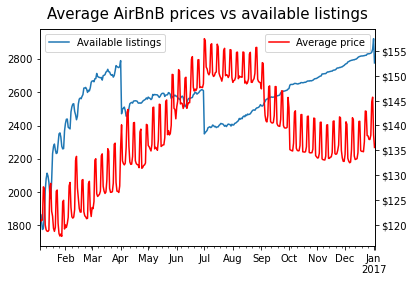

In [33]:
ax = calendar_available_day.plot(x="date", y="sum_available", label="Available listings")
plt.legend(loc="upper left")
ax.set(xlabel=None)
ax.grid(False)

ax2 = ax.twinx()
calendar_available_day.plot(x="date", y="avg_price", ax=ax2, color="r", label="Average price")
ax2.grid(False)
ax2.yaxis.set_major_formatter('${x:1.0f}')

plt.title("Average AirBnB prices vs available listings", fontsize=15, pad=10)
plt.show()

In [34]:
calendar_available_week = calendar_available.groupby("week", as_index=False).agg(
    sum_available=pd.NamedAgg(column="available", aggfunc="sum"),
    avg_price=pd.NamedAgg(column="price", aggfunc="mean"))

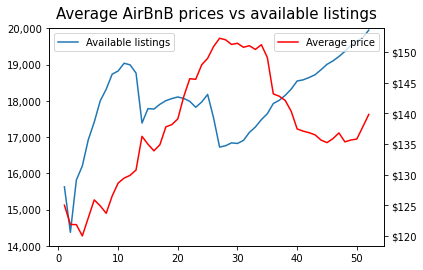

In [35]:
ax = calendar_available_week.plot(x="week", y="sum_available", label="Available listings")
ax.set_ylim([14000, 20000])
plt.legend(loc="upper left")
ax.set(xlabel=None)
ax.grid(False)
ax.yaxis.set_major_formatter("{x:,.0f}")

ax2 = ax.twinx()
calendar_available_week.plot(x="week", y="avg_price", ax=ax2, color="r", label="Average price")
ax2.grid(False)
ax2.yaxis.set_major_formatter('${x:1.0f}')

plt.title("Average AirBnB prices vs available listings", fontsize=15, pad=10)
plt.show()

In [36]:
calendar_available_month = calendar_available.groupby("month", as_index=False).agg(
    sum_available=pd.NamedAgg(column="available", aggfunc="sum"),
    avg_price=pd.NamedAgg(column="price", aggfunc="mean"))

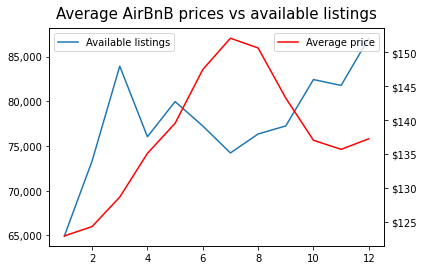

In [37]:
ax = calendar_available_month.plot(x="month", y="sum_available", label="Available listings")
plt.legend(loc="upper left")
ax.set(xlabel=None)
ax.grid(False)
ax.yaxis.set_major_formatter("{x:,.0f}")

ax2 = ax.twinx()
calendar_available_month.plot(x="month", y="avg_price", ax=ax2, color="r", label="Average price")
ax2.grid(False)
ax2.yaxis.set_major_formatter('${x:1.0f}')


plt.title("Average AirBnB prices vs available listings", fontsize=15, pad=10)
plt.show()

In [38]:
calendar_bymonth=calendar_available.groupby(calendar_available['date'].dt.strftime('%B'))['available'].sum().sort_values()
calendar_bymonth=pd.DataFrame(calendar_bymonth)

In [39]:
calendar_bymonth.reset_index(inplace=True)

In [40]:
calendar_bymonth.columns=["Month", "Available"]

In [41]:
price_bymonth=calendar_available.groupby(calendar_available['date'].dt.strftime('%B'))['price'].mean().sort_values()
price_bymonth=pd.DataFrame(price_bymonth)
price_bymonth.reset_index(inplace=True)

In [42]:
calendar_bymonth_price=calendar_bymonth.merge(price_bymonth, left_on="Month", right_on="date", how="inner")

In [43]:
calendar_bymonth_price["date"] = pd.to_datetime(calendar_bymonth_price.Month, format='%B', errors='coerce').dt.month

In [44]:
calendar_bymonth_price=calendar_bymonth_price.sort_values("date")

In [45]:
calendar_bymonth_price.reset_index(inplace=True, drop=True)

In [46]:
calendar_bymonth_price.drop(["date"], axis=1, inplace=True)

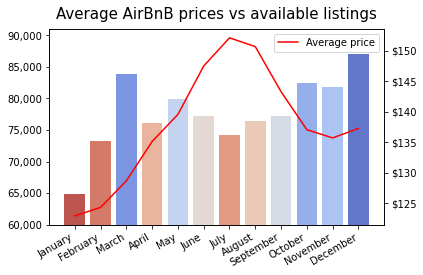

In [47]:
fig, ax = plt.subplots()
ax.set_ylim([60000, 91000])
pal = sns.color_palette("coolwarm", len(calendar_bymonth_price))
rank = calendar_bymonth_price["Available"].argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638
sns.barplot(x=calendar_bymonth_price["Month"], y=calendar_bymonth_price["Available"], palette=np.array(pal[::-1])[rank])
fig.autofmt_xdate()
ax.grid(False)
ax.yaxis.set_major_formatter("{x:,.0f}")
ax.set(xlabel=None)
ax.set(ylabel=None)

ax2 = ax.twinx()
calendar_bymonth_price.plot(x="Month", y="price", ax=ax2, legend=False, color="r", label="Average price")
ax2.grid(False)
ax2.yaxis.set_major_formatter('${x:1.0f}')
leg = ax2.legend()

plt.title("Average AirBnB prices vs available listings", fontsize=15, pad=10)
plt.show();

Let's now answer third question, and see if we can predict prices using linear regression on quantitative variables from the dataset.

In [89]:
listings.describe()

id     scrape_id       host_id  host_listings_count  \
count  3.818000e+03  3.818000e+03  3.818000e+03          3816.000000   
mean   5.550111e+06  2.016010e+13  1.578556e+07             7.157757   
std    2.962660e+06  0.000000e+00  1.458382e+07            28.628149   
min    3.335000e+03  2.016010e+13  4.193000e+03             1.000000   
25%    3.258256e+06  2.016010e+13  3.275204e+06             1.000000   
50%    6.118244e+06  2.016010e+13  1.055814e+07             1.000000   
75%    8.035127e+06  2.016010e+13  2.590309e+07             3.000000   
max    1.034016e+07  2.016010e+13  5.320861e+07           502.000000   

       host_total_listings_count     latitude    longitude  accommodates  \
count                3816.000000  3818.000000  3818.000000   3818.000000   
mean                    7.157757    47.628961  -122.333103      3.349398   
std                    28.628149     0.043052     0.031745      1.977599   
min                     1.000000    47.505088  -122.417219      1.000000   
25%                     1.000000    47.609418  -122.354320      2.000000   
50%                     1.000000    47.623601  -122.328874      3.000000   
75%                     3.000000    47.662694  -122.310800      4.000000   
max                   502.000000    47.733358  -122.240607     16.000000   

         bathrooms     bedrooms  ...  review_scores_rating  \
count  3802.000000  3812.000000  ...           3171.000000   
mean      1.259469     1.307712  ...             94.539262   
std       0.590369     0.883395  ...              6.606083   
min       0.000000     0.000000  ...             20.000000   
25%       1.000000     1.000000  ...             93.000000   
50%       1.000000     1.000000  ...             96.000000   
75%       1.000000     2.000000  ...             99.000000   
max       8.000000     7.000000  ...            100.000000   

       review_scores_accuracy  review_scores_cleanliness  \
count             3160.000000                3165.000000   
mean                 9.636392                   9.556398   
std                  0.698031                   0.797274   
min                  2.000000                   3.000000   
25%                  9.000000                   9.000000   
50%                 10.000000                  10.000000   
75%                 10.000000                  10.000000   
max                 10.000000                  10.000000   

       review_scores_checkin  review_scores_communication  \
count            3160.000000                  3167.000000   
mean                9.786709                     9.809599   
std                 0.595499                     0.568211   
min                 2.000000                     2.000000   
25%                10.000000                    10.000000   
50%                10.000000                    10.000000   
75%                10.000000                    10.000000   
max                10.000000                    10.000000   

       review_scores_location  review_scores_value  license  \
count             3163.000000          3162.000000      0.0   
mean                 9.608916             9.452245      NaN   
std                  0.629053             0.750259      NaN   
min                  4.000000             2.000000      NaN   
25%                  9.000000             9.000000      NaN   
50%                 10.000000            10.000000      NaN   
75%                 10.000000            10.000000      NaN   
max                 10.000000            10.000000      NaN   

       calculated_host_listings_count  reviews_per_month  
count                     3818.000000        3191.000000  
mean                         2.946307           2.078919  
std                          5.893029           1.822348  
min                          1.000000           0.020000  
25%                          1.000000           0.695000  
50%                          1.000000           1.540000  
75%                          2.000000           3.00

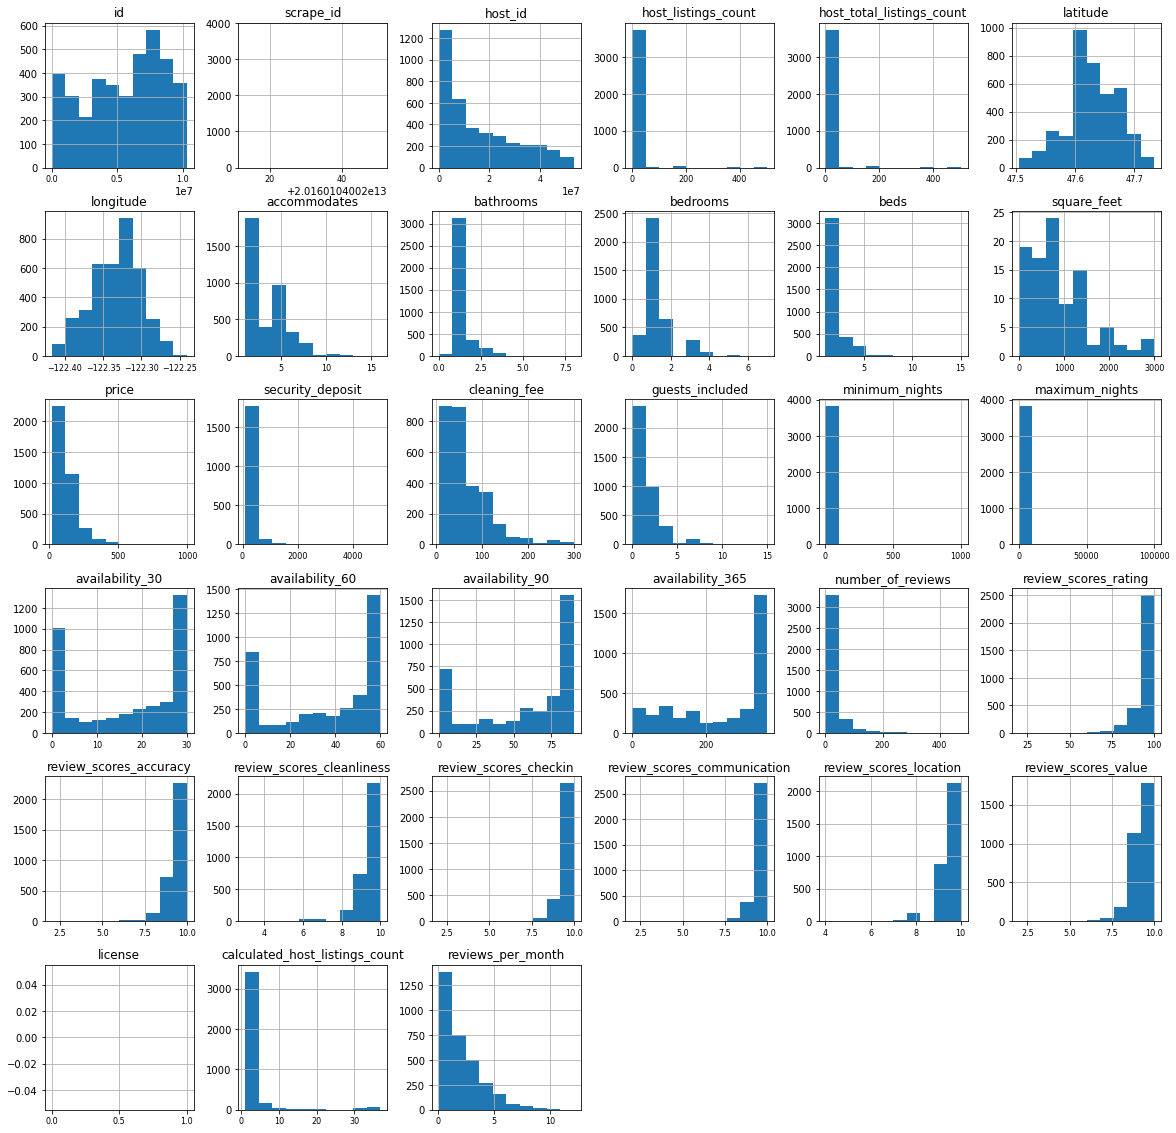

In [90]:
listings.hist(xlabelsize=8, figsize=(20,20));

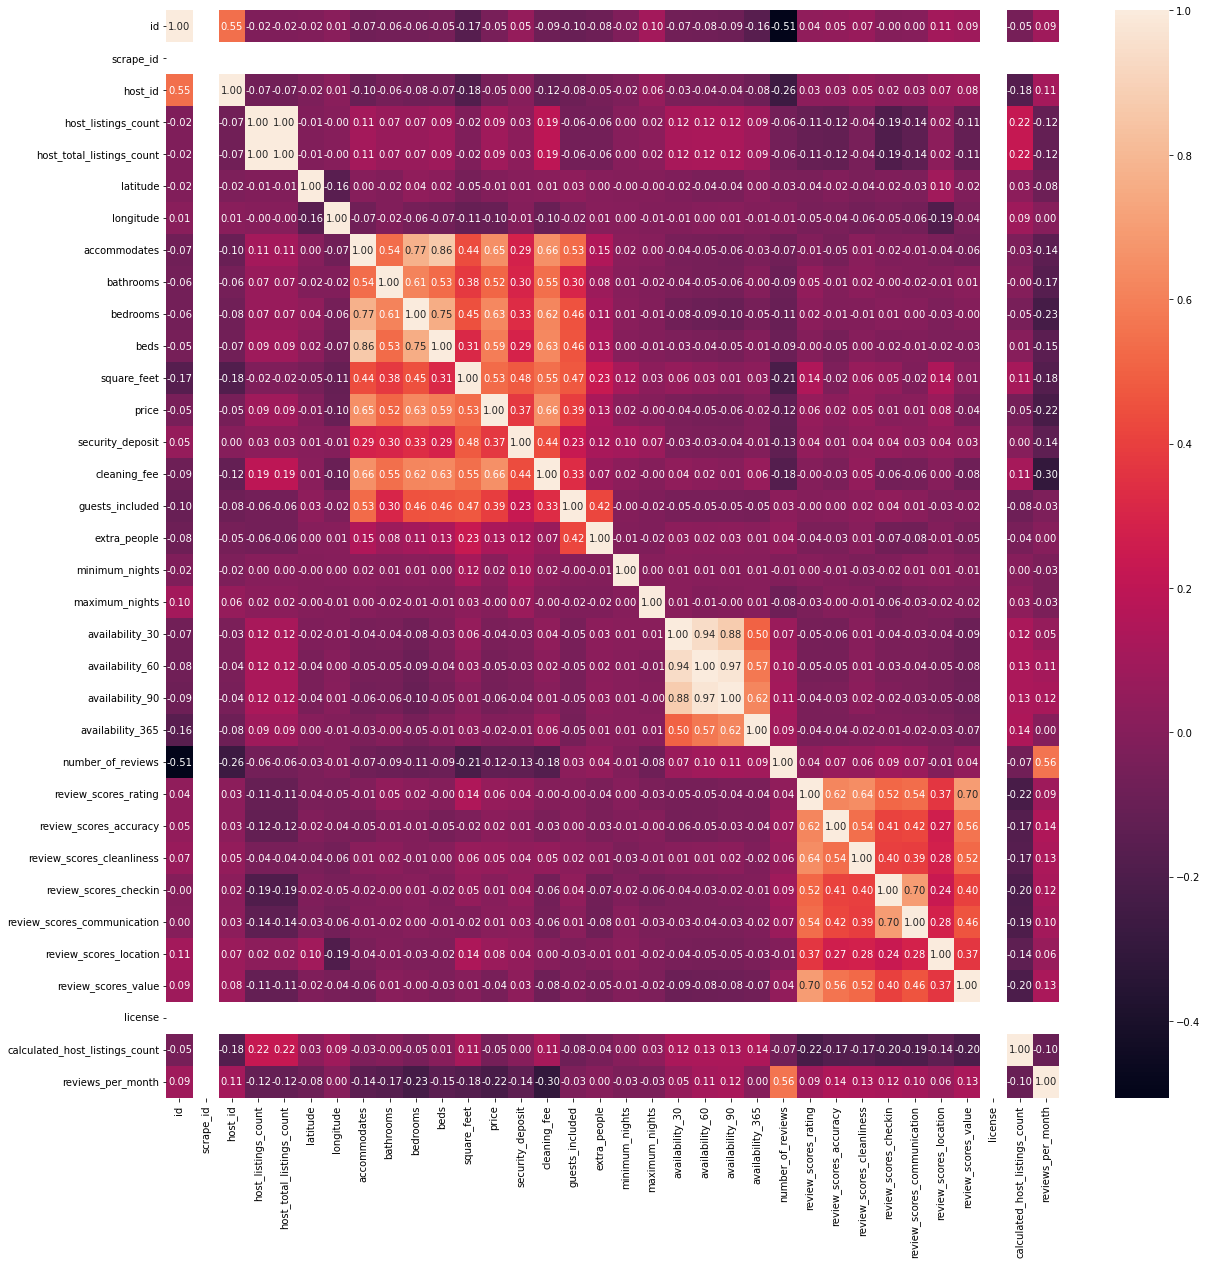

In [189]:
plt.figure(figsize=(20,20))
sns.heatmap(listings.corr(), annot=True, fmt='.2f');

In [16]:
#selecting quantitative variables
quant_vars=listings[['host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', \
    'bedrooms', 'beds', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'availability_30', \
    'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', \
    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', \
    'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month', 'price']]


In [17]:
quant_vars.shape

(3818, 27)

In [18]:
quant_vars.head()

host_listings_count  host_total_listings_count   latitude   longitude  \
0                  3.0                        3.0  47.636289 -122.371025   
1                  6.0                        6.0  47.639123 -122.365666   
2                  2.0                        2.0  47.629724 -122.369483   
3                  1.0                        1.0  47.638473 -122.369279   
4                  2.0                        2.0  47.632918 -122.372471   

   accommodates  bathrooms  bedrooms  beds  guests_included  extra_people  \
0             4        1.0       1.0   1.0                2           5.0   
1             4        1.0       1.0   1.0                1           0.0   
2            11        4.5       5.0   7.0               10          25.0   
3             3        1.0       0.0   2.0                1           0.0   
4             6        2.0       3.0   3.0                6          15.0   

   ...  review_scores_rating  review_scores_accuracy  \
0  ...                  95.0                    10.0   
1  ...                  96.0                    10.0   
2  ...                  97.0                    10.0   
3  ...                   NaN                     NaN   
4  ...                  92.0                     9.0   

   review_scores_cleanliness  review_scores_checkin  \
0                       10.0                   10.0   
1                       10.0                   10.0   
2                       10.0                   10.0   
3                        NaN                    NaN   
4                        9.0                   10.0   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         10.0                     9.0                 10.0   
1                         10.0                    10.0                 10.0   
2                         10.0                    10.0                 10.0   
3                          NaN                     NaN                  NaN   
4                         10.0                     9.0                  9.0   

   calculated_host_listings_count  reviews_per_month  price  
0                               2               4.07   85.0  
1                               6               1.48  150.0  
2                               2               1.15  975.0  
3                               1                NaN  100.0  
4                               1               0.89  450.0  

[5 rows x 27 columns]

In [19]:
quant_vars.isna().sum()

host_listings_count                 2
host_total_listings_count           2
latitude                            0
longitude                           0
accommodates                        0
bathrooms                          16
bedrooms                            6
beds                                1
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
availability_30                     0
availability_60                     0
availability_90                     0
availability_365                    0
number_of_reviews                   0
review_scores_rating              647
review_scores_accuracy            658
review_scores_cleanliness         653
review_scores_checkin             658
review_scores_communication       651
review_scores_location            655
review_scores_value               656
calculated_host_listings_count      0
reviews_per_month                 627
price       

In [20]:
#for a first iteration of the model, we will drop any rows with missing values
quant_vars_dropna=quant_vars.dropna(axis=0)

In [21]:
#split into explanatory and response variables
X=quant_vars_dropna[['host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', \
    'bedrooms', 'beds', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'availability_30', \
    'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', \
    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', \
    'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month']]

y=quant_vars_dropna[['price']]

In [22]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

In [23]:
#lm_model = LinearRegression(normalize=True) # Instantiate

lm_model = make_pipeline(StandardScaler(with_mean=False), LinearRegression()) # Instantiate
lm_model.fit(X_train, y_train); #Fit

In [24]:
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for this model was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for this model was 0.40112300941516366 on 942 values.'

Let's see if we can improve the model by imputing the mean values in place of missing values, instead of removing them.

In [25]:
quant_vars_fillna=quant_vars.fillna(quant_vars.mean())
quant_vars_fillna.head()

host_listings_count  host_total_listings_count   latitude   longitude  \
0                  3.0                        3.0  47.636289 -122.371025   
1                  6.0                        6.0  47.639123 -122.365666   
2                  2.0                        2.0  47.629724 -122.369483   
3                  1.0                        1.0  47.638473 -122.369279   
4                  2.0                        2.0  47.632918 -122.372471   

   accommodates  bathrooms  bedrooms  beds  guests_included  extra_people  \
0             4        1.0       1.0   1.0                2           5.0   
1             4        1.0       1.0   1.0                1           0.0   
2            11        4.5       5.0   7.0               10          25.0   
3             3        1.0       0.0   2.0                1           0.0   
4             6        2.0       3.0   3.0                6          15.0   

   ...  review_scores_rating  review_scores_accuracy  \
0  ...             95.000000               10.000000   
1  ...             96.000000               10.000000   
2  ...             97.000000               10.000000   
3  ...             94.539262                9.636392   
4  ...             92.000000                9.000000   

   review_scores_cleanliness  review_scores_checkin  \
0                  10.000000              10.000000   
1                  10.000000              10.000000   
2                  10.000000              10.000000   
3                   9.556398               9.786709   
4                   9.000000              10.000000   

   review_scores_communication  review_scores_location  review_scores_value  \
0                    10.000000                9.000000            10.000000   
1                    10.000000               10.000000            10.000000   
2                    10.000000               10.000000            10.000000   
3                     9.809599                9.608916             9.452245   
4                    10.000000                9.000000             9.000000   

   calculated_host_listings_count  reviews_per_month  price  
0                               2           4.070000   85.0  
1                               6           1.480000  150.0  
2                               2           1.150000  975.0  
3                               1           2.078919  100.0  
4                               1           0.890000  450.0  

[5 rows x 27 columns]

In [26]:
#split into explanatory and response variables
X=quant_vars_fillna[['host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', \
    'bedrooms', 'beds', 'guests_included', 'minimum_nights', 'maximum_nights', 'availability_30', \
    'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', \
    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', \
    'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month']]

y=quant_vars_fillna[['price']]


#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 


lm_model = make_pipeline(StandardScaler(with_mean=False), LinearRegression()) # Instantiate the model using standardized features
lm_model.fit(X_train, y_train) #Fit


#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for this model was {} on {} values (test).".format(r2_score(y_test, y_test_preds), len(y_test))


'The r-squared score for this model was 0.5251996307447911 on 1146 values (test).'

Let's try to make use of categorical columns as well.

In [27]:
categ_vars = listings.select_dtypes(include=['object'])
categ_vars.head()

listing_url last_scraped  \
0   https://www.airbnb.com/rooms/241032   2016-01-04   
1   https://www.airbnb.com/rooms/953595   2016-01-04   
2  https://www.airbnb.com/rooms/3308979   2016-01-04   
3  https://www.airbnb.com/rooms/7421966   2016-01-04   
4   https://www.airbnb.com/rooms/278830   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   
3                                                NaN   
4  Cozy family craftman house in beautiful neighb...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   
1  Chemically sensitive? We've removed the irrita...                none   
2  New modern house built in 2013.  Spectacular s...                none   
3  A charming apartment that sits atop Queen Anne...                none   
4  Cozy family craftman house in beautiful neighb...                none   

                               neighborhood_overview  \
0                                                NaN   
1  Queen Anne is a wonderful, truly functional vi...   
2  Upper Queen Anne is a charming neighborhood fu...   
3                                                NaN   
4  We are in the beautiful neighborhood of Queen ...   

                                               notes  \
0                                                NaN   
1  What's up with the free pillows?  Our home was...   
2  Our house is located just 5 short blocks to To...   
3                                                NaN   
4                                          Belltown    

                                             transit  ... has_availability  \
0                                                NaN  ...                t   
1  Convenient bus stops are just down the block, ...  ...                t   
2  A bus stop is just 2 blocks away.   Easy bus a...  ...                t   
3                                                NaN  ...                t   
4  The nearest public transit bus (D Line) is 2 b...  ...                t   

  calendar_last_scraped first_review last_review requires_license  \
0            2016-01-04   2011-11-01  2016-01-02                f   
1            2016-01-04   2013-08-19  2015-12-29                f   
2            2016-01-04   2014-07-30  2015-09-03                f   
3            2016-01-04          NaN         NaN                f   
4            2016-01-04   2012-07-10  2015-10-24                f   

  jurisdiction_names instant_bookable cancellation_policy  \
0         WASHINGTON                f            moderate   
1         WASHINGTON                f              strict   
2         WASHINGTON                f              strict   
3         WASHINGTON                f            flexible   
4         WASHINGTON                f              strict   

  require_guest_profile_picture require_guest_phone_verification  
0                             f                                f  
1                             t                                t  
2                             f                                f  
3                             f                                f  
4                             f                

In [28]:
categ_vars.columns

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'is_location_exact',
       'property_type', 'room_type', 'bed_type', 'amenities', 'weekly_price',
       'monthly_price', 'calendar_updated', 'has_availability',
       'calendar_last_scraped', 'first_review', 'last_review',
       'requires_license', '

It doesn't really make sense to make dummy variables for url for example, since it is unique for each listing, and it's not really a category in a sense that each listing is actually its own category.


A selection of categorical variables that makes most logical sense, and that has a positive contribution is therefore selected.

In [29]:
#selecting quantitative and categorical variables
quant_and_categ_vars=listings[['host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', \
    'bedrooms', 'beds', 'guests_included', 'minimum_nights', 'maximum_nights', 'availability_30', \
    'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', \
    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', \
    'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'reviews_per_month', 'price',\
    'zipcode', 'property_type', 'room_type', 'host_is_superhost', 'host_response_time', 'is_location_exact',\
    'require_guest_profile_picture', 'require_guest_phone_verification']]


listing_categ_cols=['zipcode', 'property_type', 'room_type', 'host_is_superhost', 'host_response_time', 'is_location_exact',\
                    'require_guest_profile_picture', 'require_guest_phone_verification']       

In [30]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [31]:
listings_dummy = create_dummy_df(quant_and_categ_vars, listing_categ_cols, dummy_na=False) #Use your newly created function

print(listings_dummy.shape)

(3818, 77)


In [32]:
# Mean function
fill_mean = lambda col: col.fillna(col.mean())
# Fill the mean
listings_dummy = listings_dummy.apply(fill_mean, axis=0)

In [36]:
#Split into explanatory and response variables
X = listings_dummy.drop("price", axis=1)
y = listings_dummy["price"]


#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lm_model = make_pipeline(StandardScaler(with_mean=False), LinearRegression()) # Instantiate
lm_model.fit(X_train, y_train); #Fit

#Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

#Print training and testing score
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

The rsquared on the training data was 0.5977303519921988.  The rsquared on the test data was 0.6082481430626422.
